In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from kneed import KneeLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
#import plotly.express as px

In [3]:
bike_spring = pd.read_csv("bike_spring.csv")
bike_spring.head()

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,1,2018-03-01 00:00:00,2018-03-01,0,Spring,Holiday,Yes,71,2.0,96,1.3,18940,1.4,0.0,2.0,0
1,2,2018-03-01 01:00:00,2018-03-01,1,Spring,Holiday,Yes,147,2.1,97,0.2,8590,1.6,0.0,0.0,0
2,3,2018-03-01 02:00:00,2018-03-01,2,Spring,Holiday,Yes,180,2.0,97,1.0,5800,1.5,0.0,0.0,0
3,4,2018-03-01 03:00:00,2018-03-01,3,Spring,Holiday,Yes,92,1.6,97,2.3,4690,1.1,0.0,0.1,0
4,5,2018-03-01 04:00:00,2018-03-01,4,Spring,Holiday,Yes,28,1.6,97,1.1,6360,1.1,0.0,0.0,0


In [4]:
bike_spring_col = list(bike_spring.columns)
bike_spring_numeric_col = list(bike_spring.describe().columns)
diff_names = []
for i in bike_spring_col:
	if i not in bike_spring_numeric_col:
		diff_names.append(i)
diff_names

['datetime', 'date', 'season', 'holiday', 'open']

In [5]:
bike_spring2 = bike_spring.copy()
bike_spring2.drop(columns = diff_names,inplace=True)
#bike_spring2.drop(columns = ['rent_count'], inplace = True)
bike_spring2.drop(columns = ['rent_count','dewpoint_temp'], inplace = True)
bike_spring2.head()

,Unnamed: 0,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall
0,1,0,2.0,96,1.3,18940,0.0,2.0,0
1,2,1,2.1,97,0.2,8590,0.0,0.0,0
2,3,2,2.0,97,1.0,5800,0.0,0.0,0
3,4,3,1.6,97,2.3,4690,0.0,0.1,0
4,5,4,1.6,97,1.1,6360,0.0,0.0,0


In [9]:
bike_spring3 = bike_spring2.iloc[: , 1:-1]
bike_spring3.head()

,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall
0,0,2.0,96,1.3,18940,0.0,2.0
1,1,2.1,97,0.2,8590,0.0,0.0
2,2,2.0,97,1.0,5800,0.0,0.0
3,3,1.6,97,2.3,4690,0.0,0.1
4,4,1.6,97,1.1,6360,0.0,0.0


In [10]:
bike_spring3.describe()

,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.00000
mean,11.500000,13.046694,58.776721,1.874592,12403.645833,0.688786,0.18288
std,6.923755,6.617154,22.573616,1.071014,6379.583214,0.986609,1.20144
min,0.000000,-6.600000,0.000000,0.100000,270.000000,0.000000,0.00000
25%,5.750000,8.200000,42.000000,1.100000,6067.500000,0.000000,0.00000
50%,11.500000,13.300000,58.000000,1.700000,13075.000000,0.060000,0.00000
75%,17.250000,18.100000,77.250000,2.500000,19112.500000,1.145000,0.00000
max,23.000000,29.400000,98.000000,7.400000,20000.000000,3.520000,35.00000


In [11]:
_ , p_value = calculate_bartlett_sphericity(bike_spring3)
p_value

0.0

In [12]:
_, kmo_score = calculate_kmo(bike_spring3)
kmo_score 

0.604138782648966

In [23]:
colnames = list(bike_spring3.columns)

scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike_spring3))

scaled_features.columns = colnames

In [14]:
N = 7
pca = PCA(n_components=N)
pca.fit(scaled_features)


PCA(n_components=7)

In [15]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))


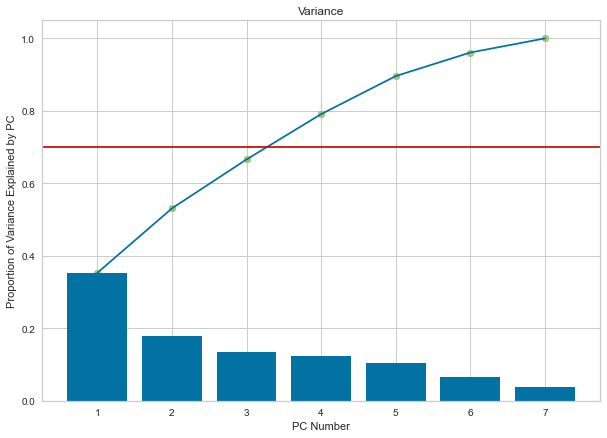

In [16]:

x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')

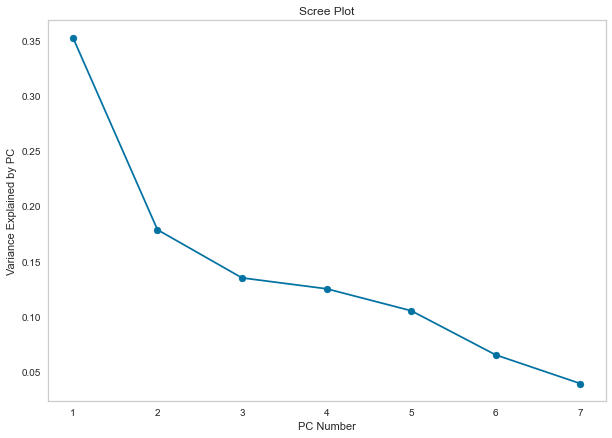

In [17]:

plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [18]:

kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow


2

In [19]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

In [20]:

def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))



In [21]:
evaluate_pcs(2,scaled_features[colnames])

,PC1,PC2
hour,0.622179,
temperature,0.718207,
humidity,,0.763946
wind_speed,0.619308,
visibility,,-0.775962
solar_radiation,0.690983,
rainfall,,0.602588


In [22]:
print(CronbachAlpha(scaled_features[['hour','temperature','wind_speed','solar_radiation']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['humidity','rainfall']])) #Reliability of PC2

0.6133089104771201
0.39129919866160723
